# ***Assignment 3: CO<sub>2</sub> Global Data***
This assignment is due on Thursday 2024-1-25, before class. Change the name of your notebook to tpp_assignment_3_sunetID.ipynb Share your completed notebook with the TAs akroo@stanford.edu & flora221@stanford.edu using the share banner at the top. For help submitting, see the canvas walkthrough. If you are still having technical difficulties, email us before the deadline.


###**INTRODUCTION TO THE ASSIGNMENT**

In this week’s assignment will analyze NASA's OCO2 global satellite data with the goal of answering the question: how/why is the concentration of CO2 changing in the atmosphere over space and time?


###**DATA SETS**
For this assignment, you will be using NASA's OCO2 Dataset.

For more info see the project's website: https://ocov2.jpl.nasa.gov/

####**Units:**
The unit for reporting the concentration of CO<sub>2</sub> is ppm (parts per million).

##**TOOLBOX**
All the Python functions and packages you will use in this assignment are in the toolbox for the course. We add new tools to the toolbox with each assignment as new ways of analyzing and visualizing data are introduced.

https://colab.research.google.com/drive/1gQxlpnogdJzykfNqjIGO4VLMnHHhrvcC?usp=sharing

This week you will be working with gridded data - envision this as a stack of maps, with each map showing the spatial variation in a measurement at a set time.

*numpy* (numbers for python) is a package of python tools that handle the mathematical operations.

*pandas* (referred to as pd in lines of code) is a package of python tools that can be used to work efficiently with datasets, taken into pandas and referred to as dataframes.

*matplotlib* is a package that is useful for generating plots.

*xarray* is a package in python that builds off of pandas to support working with gridded data.

*cartopy* is a package designed for geospatial data processing in order to produce maps and other geospatial data analyses.

*datetime* is a package that helps interpret months, years etc. as a single date/time object


## **Learning Goals for the Week**
(where the course learning goals are in plain text, and the focus this week is in italics)

- become familiar with the wide range of sensors available to study various components of the Earth system. These include sensors on satellites, aircraft, ground-based platforms, and deployed above or beneath the surface on land or water. *This week we will learn about the measurement of CO2 in the atmosphere from satellites.*

- work with various sources of data, learning how to access, analyze, synthesize, and describe the data to quantify trends; think critically and creatively about how to project these trends into the future. *This week you will learn how to analyze gridded data.*

- become motivated to think about new sensors and new ways of using sensor data to study the planet. *This week you will consider the advantages and disadvantages of satellite forms of measuring CO2.*

## **In Class Assignment**


#### 1) **Install and Import Packages**: numpy, pandas, matplotlib, xarray, cartopy, widgets, and datetime (See Toolbox)

#### 2) **Getting and Reviewing the Data**

Instead of having an excel sheet style grid of data, we have carbon dioxide measurements across the world and at many different points in time

Use the code below to pull the data from the website it is hosted on into your assignment and then load that data from a file into the assignment.

In [ ]:
!git clone https://premonition.stanford.edu/sgkang09/taking_the_pulse_atmosphere_data.git
import warnings
warnings.filterwarnings('ignore')
co2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co2.nc')

##### **a)** Investigate the dataframe to see what data you are working with. In 3-5 sentences, explain what data is in the dataset and how it is structured.


#### 3) **Guided Data Analysis**

In class we will be focusing our data analysis around the question – **which countries are responsible for co2 emissions?**


##### **a)** Spend 3-8 minutes googling who the top emitters of carbon dioxide are. How was this list created? What were the data sources?


Now let’s dig into the satellite data to inform this

##### **b)** Using the toolbox explore the data graphically (plotting). There are various forms of data analysis you can experiment with: Plot **different months** and plot the **average concentration** around the world

##### **c)** What do you notice about the difference between the monthly snapshots?


##### **d)** What overall trends do you see in the dataset over time?


##### **e)** Are there locations that visually look like they might be sources of carbon dioxide? Are there locations that look like they might be sinks of carbon dioxide. Do these correspond to what you expect? Where they do not align, explain why you think that it does not.

##### **f)** One approach to looking at what countries are polluting is to assume that a higher concentration of co2 above the country means that they are producing more. In the code below I have pulled the data that is within the bounds of each country and taken the average of the temporally averaged co2 data. The resulting dataframe has the country name and the average concentration of co2 above that country. Is this approach a good way of determining who is polluting? Are these countries the top emitters in the world? Why? (5-8 sentances)

In [ ]:
# Function for determining average co2 over each country
# You do not need to understand this

from shapely.geometry import mapping
import cartopy.crs as ccrs
import rioxarray

#import requisit packages and read file from repository
import geopandas as gpd
gdf_boundaries = gpd.read_file("./taking_the_pulse_atmosphere_data/world-administrative-boundaries.geojson")

# set the index of the dataset to be the country names for easy access
country_names = np.sort(gdf_boundaries.name.values)
gdf_boundaries = gdf_boundaries.set_index('name')

def country_clipped_averages(dataset,bounds):
    '''Function that takes in dataset and gdf_boundaries and returns dataframe
    of average value of co2 over that country.
    Example of use: c_vals = country_clipped_averages(co2_data, gdf_boundaries)'''
    country_vals = pd.DataFrame(index=bounds.index)
    country_vals.co2 = 0
    country_names = gdf_boundaries.index
    for country in country_names:
      data_copy = dataset
      country_boundary = bounds.loc[[country]]
      country_boundary.crs
      data_copy.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
      data_copy.rio.write_crs(4326, inplace=True)
      try:
        data_clipped = data_copy.rio.clip(
            country_boundary.geometry.apply(mapping),
            country_boundary.crs,
            drop=True
        )
      except:
        country_vals.drop('Cyprus')
        pass
      country_vals.at[country, 'co2'] = float(data_clipped.co2.mean(dim=['lon','lat','time']))
    return country_vals

In [ ]:
# We are calling the function to tell us how much co2 is in each country
# This function takes a while to run, be patient
c_vals = country_clipped_averages(co2_data, gdf_boundaries);

# sort values and look at the top 10 countries
c_vals.sort_values('co2',ascending=False).head(10)

,co2
name,
Taiwan,409.149043
Guadeloupe,409.149043
Republic of Korea,408.935868
Montserrat,408.935868
Lao People's Democratic Republic,408.691470
Vietnam,408.639173
Japan,408.586088
Thailand,408.502008
Bangladesh,408.468565


The following code cell plots these values

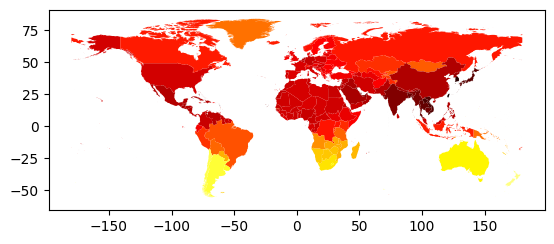

In [ ]:
#add average co2 values to the geospatial dataframe
gdf_boundaries.insert(0, 'co2', c_vals['co2'])

#plot all countries with the color corresponding to the co2 average value for that country
gdf_boundaries.plot(column='co2', cmap='hot_r');

##### **g)** Another approach is to look at the change of co2 over time over a country. Make a trend map of the co2 concentration that shows how the concentration of co2 is changing at each location in the world. (Use the toolbox to do this)

##**After Class Assignment**

##### **a)** Compare the sattelitte data nearest to Mauna Loa to your findings from assignment 2 by plotting that pixel over time on the same plot as the monthly co2 data from the NOAA dataset (Mauna Loa). Plot only the years of Mauna Loa data that are also covered by the sattelite data.
Hint: To do this you will have to look up the lat/lon coordinates of Mauna Loa

##### **b)** Describe the differences and similarities observed in part a. What do you think causes these differences? Spend 10-15 minutes digging into how the sattelite data is collected and processed. Why do you think there are differences between the sattelite and ground based measurements? Which one is more "correct" and why? Do you believe the sattelite data to be an accurate indication of the co2 given what you observe?
(write the equivelent of 1 page on these topics)

##### **bonus:** If you want to learn more about how what you have done in this assignment relates to how atmospheric scientists are attempting exactly what you have described and investigated in this assignment check out the following links. I reccomend at least reading the first one.

1. General audience press release about JPL's conclusions about carbon emissions by country: https://www.jpl.nasa.gov/news/nasa-space-mission-takes-stock-of-carbon-dioxide-emissions-by-countries

2. Intermediate step in the data analysis where they have included bottom up information and describe how they use it: https://ceos.org/gst/carbon-dioxide.html

3. Scientific paper describing thouroughly the methods and approaches used with description of the tradeoffs made: https://essd.copernicus.org/articles/15/963/2023/